![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [5]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [6]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<AxesSubplot: title={'center': 'Sentiminetos por aerolínea'}, xlabel='airline'>

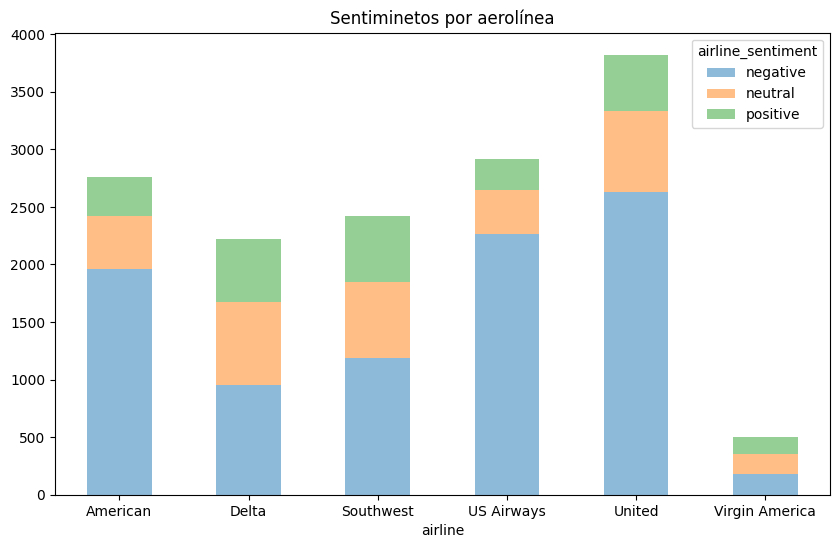

In [7]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

In [8]:
tweets["text"]

tweet_id
570306133677760513                  @VirginAmerica What @dhepburn said.
570301130888122368    @VirginAmerica plus you've added commercials t...
570301083672813571    @VirginAmerica I didn't today... Must mean I n...
570301031407624196    @VirginAmerica it's really aggressive to blast...
570300817074462722    @VirginAmerica and it's a really big bad thing...
                                            ...                        
569587686496825344    @AmericanAir thank you we got on a different f...
569587371693355008    @AmericanAir leaving over 20 minutes Late Flig...
569587242672398336    @AmericanAir Please bring American Airlines to...
569587188687634433    @AmericanAir you have my money, you change my ...
569587140490866689    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

### Liberias y Variables de interés y predicción

In [9]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhoyoso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dhoyoso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhoyoso\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dhoyoso\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [10]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':0,'neutral':1,'positive':2})

In [11]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [12]:
# Celda 1

# Paso 1: crear objeto CountVectorizer y aplicarlo al set de entrenamiento
vect = CountVectorizer()
X_train_vect = vect.fit_transform(X_train)

# Paso 2: aplicar el objeto CountVectorizer ya entrenado al set de test
X_test_vect = vect.transform(X_test)

# Paso 3: crear objeto RandomForestClassifier y ajustarlo al set de entrenamiento
rf = RandomForestClassifier()
rf.fit(X_train_vect, y_train)

# Paso 4: predecir las etiquetas de sentimiento para el set de test
y_pred = rf.predict(X_test_vect)

# Paso 5: evaluar el desempeño del modelo usando la métrica de accuracy
from sklearn.metrics import accuracy_score
accuracy_cv= accuracy_score(y_test, y_pred)
print("Accuracy CountVectorizer:", accuracy_cv)

Accuracy CountVectorizer: 0.7709023178807947


### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [13]:
# Celda 2
# Paso 1: crear objeto CountVectorizer y eliminar stopwords
vect = CountVectorizer(stop_words='english')

# Paso 2: aplicar el objeto CountVectorizer ya entrenado al set de entrenamiento
X_train_vect = vect.fit_transform(X_train)

# Paso 3: aplicar el objeto CountVectorizer ya entrenado al set de test
X_test_vect = vect.transform(X_test)

# Paso 4: crear objeto RandomForestClassifier y ajustarlo al set de entrenamiento
rf = RandomForestClassifier()
rf.fit(X_train_vect, y_train)

# Paso 5: predecir las etiquetas de sentimiento para el set de test
y_pred = rf.predict(X_test_vect)

# Paso 6: evaluar el desempeño del modelo usando la métrica de accuracy
from sklearn.metrics import accuracy_score
accuracy_sw = accuracy_score(y_test, y_pred)
print("Accuracy Stopwords:", accuracy_sw)

Accuracy Stopwords: 0.7634519867549668


### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [14]:
# Celda 3

# Paso 1: crear objeto CountVectorizer quitando stop words y cambiando el tokenizer pos_tagger por el de nltk
vect = CountVectorizer(tokenizer=lambda text: [word for word, pos in nltk.pos_tag(nltk.word_tokenize(text))])

# Paso 2: crear objeto WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Paso 3: definir función para lematizar los textos
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in text.split()])

# Paso 4: aplicar el objeto CountVectorizer ya entrenado al set de entrenamiento usando la función de lematización definida en el paso 3
X_train_vect = vect.fit_transform(X_train.apply(lemmatize_text))

# Paso 5: aplicar el objeto CountVectorizer ya entrenado al set de test usando la función de lematización definida en el paso 3
X_test_vect = vect.transform(X_test.apply(lemmatize_text))

# Paso 6: crear objeto RandomForestClassifier y ajustarlo al set de entrenamiento
rf = RandomForestClassifier()
rf.fit(X_train_vect, y_train)

# Paso 7: predecir las etiquetas de sentimiento para el set de test
y_pred = rf.predict(X_test_vect)

# Paso 8: evaluar el desempeño del modelo usando la métrica de accuracy
from sklearn.metrics import accuracy_score
accuracy_lemmatized_verbs = accuracy_score(y_test, y_pred)
print("Accuracy con Lematización de verbos:", accuracy_lemmatized_verbs)

Accuracy con Lematización de verbos: 0.7717301324503312


### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [15]:
# Celda 4

stop_words = set(stopwords.words('english'))

# Paso 1: crear objeto CountVectorizer quitando stop words y cambiando el tokenizer pos_tagger por el de nltk
vect = CountVectorizer(stop_words=list(stop_words) , tokenizer=lambda text: [word for word, pos in nltk.pos_tag(nltk.word_tokenize(text))])

# Paso 2: crear objeto WordNetLemmatizer y PorterStemmer
lemmatizer = WordNetLemmatizer()

# Paso 3: aplicar pre procesamientos (lematizacion y limpieza de caracteres especiales)
def preprocess_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    text = ' '.join(lemmatized_words)
    return text

X_train_preprocessed = X_train.apply(lambda x: preprocess_text(x))
X_test_preprocessed = X_test.apply(lambda x: preprocess_text(x))

# Paso 4: aplicar el objeto CountVectorizer ya entrenado al set de entrenamiento preprocesado
X_train_vect = vect.fit_transform(X_train_preprocessed)

# Paso 5: aplicar el objeto CountVectorizer ya entrenado al set de prueba preprocesado
X_test_vect = vect.transform(X_test_preprocessed)

# Paso 6: crear objeto RandomForestClassifier y ajustarlo al set de entrenamiento
rf = RandomForestClassifier()
rf.fit(X_train_vect, y_train)

# Paso 7: predecir las etiquetas de sentimiento para el set de test
y_pred = rf.predict(X_test_vect)

# Paso 8: evaluar el desempeño del modelo usando la métrica de accuracy
from sklearn.metrics import accuracy_score
accuracy_all_preprocessing = accuracy_score(y_test, y_pred)
print("Accuracy con eliminación de Stop Words, Lematización de verbos y CountVectorizer:", accuracy_all_preprocessing)

Accuracy con eliminación de Stop Words, Lematización de verbos y CountVectorizer: 0.7752483443708609


### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

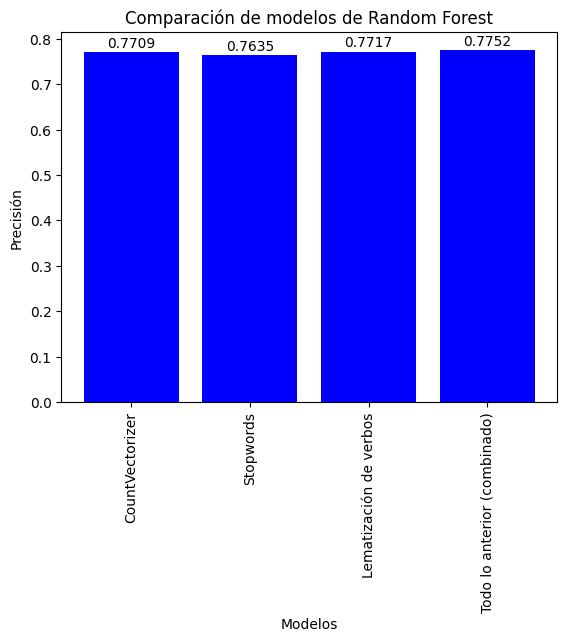

In [16]:
# Celda 5
# definir los datos de precisión
models = ['CountVectorizer', 'Stopwords', 'Lematización de verbos', 'Todo lo anterior (combinado)']
precision = [accuracy_cv, accuracy_sw, accuracy_lemmatized_verbs, accuracy_all_preprocessing]

# configurar el gráfico
fig, ax = plt.subplots()
ax.bar(models, precision, color='blue')
ax.set_ylabel('Precisión')
ax.set_xlabel('Modelos')
ax.set_title('Comparación de modelos de Random Forest')
ax.tick_params(axis='x', labelrotation=90)

# agregar etiquetas de valores a las barras
for i in range(len(models)):
    ax.text(i, precision[i]+0.01, str(round(precision[i], 4)), ha='center')

# mostrar el gráfico
plt.show()

**Conclusiones:**

* Se logra concluir que no siempre eliminar stop words puede aumentar la precisión o accuracy de un clasificador puesto que se puede perder información importante, el tamaño del vocabulario puede disminuir considerablemente o se puede generar ruido en los datos. Estas tres casuisticas toman aún mayor relevancia en este caso que son twits.

* Un modelo de clasificación de tweets que elimina stopwords y utiliza CountVectorizer puede tener algunas desventajas, como la pérdida de información y problemas de polisemia (cuando una palabra tiene varios significados y puede ser utilizada en diferentes contextos. Esto puede confundir al modelo y disminuir la precisión).

* Se logra concluir que la lematización por sí sola y combinada con otros preprocesamientos logra aumentar considerablemente la precisión, tanto de manera individual, como combinando (en donde aumenta aún más).

* Un modelo que también realiza la lematización de verbos puede mejorar la precisión y la interpretación del modelo, al reducir la dimensionalidad, reducir el ruido en los tweets y mejorar la calidad de los datos utilizados para el entrenamiento.

Como conclusión final de acuerdo con el accuracy obtenido, la lematización de verbos es la técnica más útil para mejorar la eficacia de un modelo de clasificación de tweets, en especial, si se combina con otras técnicas de pre procesamiento como la eliminación de stop words.